In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys
from optic.models.devices import photodiode, basicLaserModel, pm
from optic.models.channels import linearFiberChannel
from optic.dsp.core import phaseNoise, firFilter, pulseShape, signal_power ,delaySignal
from optic.models.amplification import OSA, get_spectrum
from optic.utils import parameters
from optic.plot import plotPSD
from scipy.constants import h, c
from matplotlib import mlab
import scipy.signal as signal
from scipy.signal import hilbert, lfilter, firwin, freqz
from scipy.signal.windows import hamming
from scipy.ndimage import shift
from IPython.display import display, Math
from commpy.utilities import upsample
from tqdm.notebook import tqdm  # Needs installation of jupyter and ipywidgets packages

sys.path.append('..\..\Functions')

from laser_dfb import *
from laser_cw import *
from AuxiliaryFunctions import *

fontSmall = {'family':'serif', 'weight':'normal', 'size':12}
font = {'family':'serif', 'weight':'normal', 'size':16}
fontTitle = {'family':'serif', 'weight':'normal', 'size':20}

# Parameters and simulation

In [8]:
# simulation parameters
SpS = 64*4    # Samples per Symbol
Rs = 170e6  # Symbol rate (for OOK case Rs = Rb)

Tsymb = 1/Rs       # Symbol period in seconds
Fs = 1/(Tsymb/SpS) # Signal sampling frequency (samples/second)
Ts = 1/Fs          # Sampling period

# generate pseudo-random bit sequence
bitsTx = np.ones(2**14)
n = np.arange(0, bitsTx.size)

lmbd = 1540e-9       # Central Wavelength [m]
KConst = 0.5         # Coupling Constant (0 to 1)
KPhase = (1/2)*np.pi   # Coupling Phase Delay between arms (rad)

SMFLen = 12          # Single Mode Fiber Length (km)
SMFAtt = 0.22        # Single Mode Fiber Attenuation (dB/km)
SMFGamma = 1.2       # Single Mode Fiber Nonlinear parameter (1/(W*km))
SMFDisp = 16         # Single Mode Fiber Chromatic Dispersion parameter (ps/nm/km)
tau = SMFLen/(c*1e-3)    # Fiber Delay

mFreq = 2e9     # Frequency of the electrical modulating signal (Hz)
mPhase = 0      # Phase of the electrical modulating signal (Radians)
R = 1           # Photodiode Responsivity

tArray = np.arange(0,SpS*len(bitsTx))*Ts

laser_parameters = parameters()
laser_parameters.P = 10 # laser power [dBm] 
laser_parameters.lw = 6e6 # laser linewidth [Hz] 
laser_parameters.RIN_var = 1e-20 # variance of the RIN noise 
laser_parameters.Fs = Fs # sampling rate [samples/s]
laser_parameters.Ns = SpS*bitsTx.size # number of signal samples

OptSig = basicLaserModel(laser_parameters)

print(f'Samples: {SpS*bitsTx.size}')
print(f'Total sample time: {SpS*len(bitsTx)*Ts*1e6} us')
print(f'Sampling period: {Ts*1e12} ps')
print(f'Sampling frequency: {Fs*1e-9} Gsample/s')
print(f'Linewidth: {laser_parameters.lw * 1e-6} MHz')
print(f'Power: {laser_parameters.P} dBm')

Samples: 4194304
Total sample time: 96.37647058823529 us
Sampling period: 22.977941176470587 ps
Sampling frequency: 43.52 Gsample/s
Linewidth: 6.0 MHz
Power: 10 dBm


BestleftMark: 194670421.77585414 MHz
BestrightMark: 194670433.0306051 MHz


<IPython.core.display.Math object>

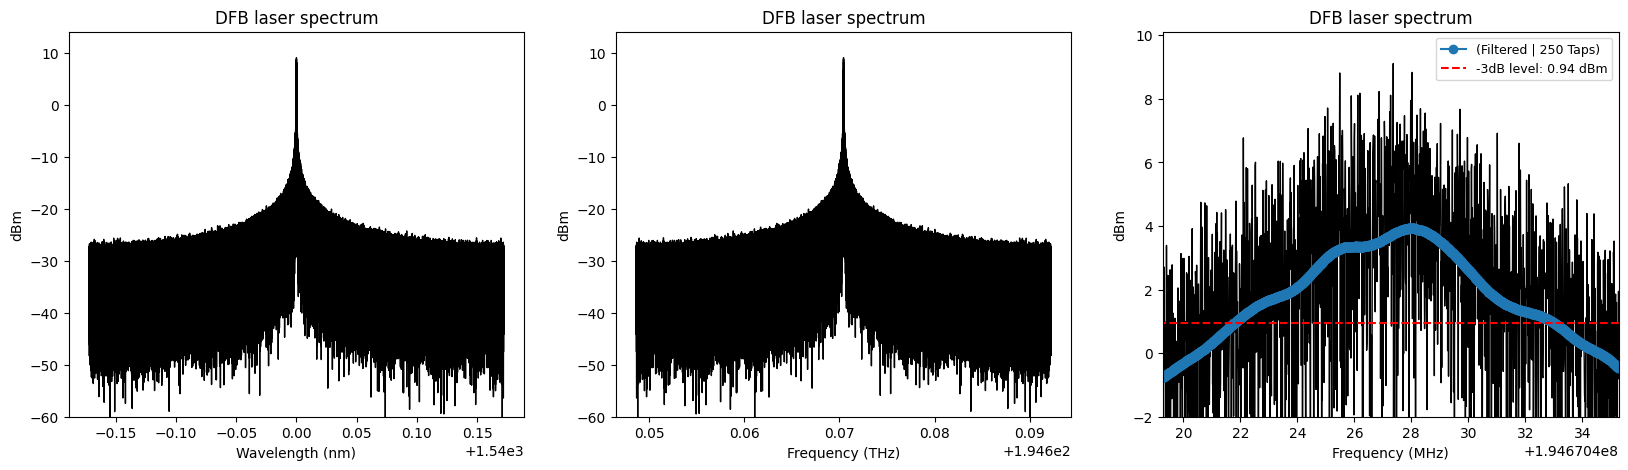

In [13]:
fig, ax = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(20)

# spectrum, freq = mlab.magnitude_spectrum(OptSig, Fs=Fs, window=mlab.window_none)
spectrum = np.abs(np.fft.fft(OptSig,norm='forward'))
freq = np.fft.fftfreq(len(tArray),d=tArray[-1]/len(OptSig))
ax[0].plot(c/(freq+c/lmbd)*1e9, 10*np.log10(1e3*spectrum), color='black',linewidth = 1)
# ax[0].set_xlim(1538,1542)
ax[0].set_ylim(-60,np.max(10*np.log10(1e3*spectrum))+5)
ax[0].set_ylabel('dBm')
ax[0].set_xlabel('Wavelength (nm)')
ax[0].set_title('DFB laser spectrum')

spectrum = np.abs(np.fft.fft(OptSig,norm='forward'))
freq = np.fft.fftfreq(len(tArray),d=tArray[-1]/len(OptSig))
ax[1].plot((freq+c/lmbd)*1e-12, 10*np.log10(1e3*spectrum), color='black',linewidth = 1)
# ax[0].set_xlim(1538,1542)
ax[1].set_ylim(-60,np.max(10*np.log10(1e3*spectrum))+5)
ax[1].set_ylabel('dBm')
ax[1].set_xlabel('Frequency (THz)')
ax[1].set_title('DFB laser spectrum')

centerFreq = c/lmbd
cutLims = [c/lmbd - 100e6 , c/lmbd + 100e6]

spectrum = np.concatenate((spectrum[int(len(freq)/2):],spectrum[:int(len(freq)/2)]))
freq = np.concatenate((freq[int(len(freq)/2):],freq[:int(len(freq)/2)]))
initFreq = int((cutLims[0]-freq[0]-centerFreq)/(freq[-1]-freq[0])*len(freq))
endFreq = int((cutLims[1]-freq[0]-centerFreq)/(freq[-1]-freq[0])*len(freq))

freq = (freq+c/lmbd)[initFreq:endFreq]
spectrum =  10*np.log10(1e3*spectrum[initFreq:endFreq])

# Filter spectrum
Ntaps = 250
b = signal.firwin(numtaps = Ntaps, cutoff = 1e-5, window='hamming')
FilteredSpec = firFilter(b, spectrum)[Ntaps:-Ntaps]  

ax[2].plot(freq*1e-6, spectrum, color='black',linewidth = 1)
ax[2].plot(freq[Ntaps:-Ntaps]*1e-6,FilteredSpec,'-o', label=f'(Filtered | {Ntaps} Taps)')
ax[2].hlines(np.max(FilteredSpec)-3,xmin=cutLims[0]*1e-6, xmax=cutLims[1]*1e-6, color='red', linestyle='--', label=f'-3dB level: {np.round(np.max(FilteredSpec)-3,2)} dBm')
ax[2].set_xlim(c*1e-6/lmbd - 8 , c*1e-6/lmbd + 8)
ax[2].set_ylim(-2,np.max(spectrum)+1)
ax[2].set_ylabel('dBm')
ax[2].set_xlabel('Frequency (MHz)')
ax[2].set_title('DFB laser spectrum')
ax[2].legend(fontsize=9)

BestrightMark = 0
BestleftMark = 0

freq = freq[Ntaps:-Ntaps] 
spectrum = spectrum[Ntaps:-Ntaps] 

for i in range(len(FilteredSpec)-1):
    if FilteredSpec[i+1] > np.max(FilteredSpec)-3 and FilteredSpec[i] <= np.max(FilteredSpec)-3:
        # print(f'leftMark between {np.round(freq[i]*1e-6,2)} and {np.round(freq[i+1]*1e-6,2)} MHz')
        leftMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freq[i+1]-freq[i]) + freq[i]
        if (np.abs(leftMark-centerFreq) <= np.abs(BestleftMark-centerFreq) and leftMark < centerFreq):
            BestleftMark = leftMark
            print(f'BestleftMark: {BestleftMark*1e-6} MHz')
    elif FilteredSpec[i+1] <= np.max(FilteredSpec)-3 and FilteredSpec[i] > np.max(FilteredSpec)-3:
        # print(f'rightMark between {np.round(freq[i]*1e-6,2)} and {np.round(freq[i+1]*1e-6,2)} MHz')
        rightMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freq[i+1]-freq[i]) + freq[i]
        if (np.abs(rightMark-centerFreq) <= np.abs(BestrightMark-centerFreq) and rightMark > centerFreq):
            BestrightMark = rightMark
            print(f'BestrightMark: {BestrightMark*1e-6} MHz')

delF = BestrightMark*1e-6-BestleftMark*1e-6
display(Math('Measured~Linewidth = %5.6f~MHz~~~|~~~Corrected~Linewidth~(/2) = %5.6f~MHz' %(delF,delF/2)))

# Optical modulator

Modulator used: https://www.eospace.com/small-form-factor-125-gb/s-modulator

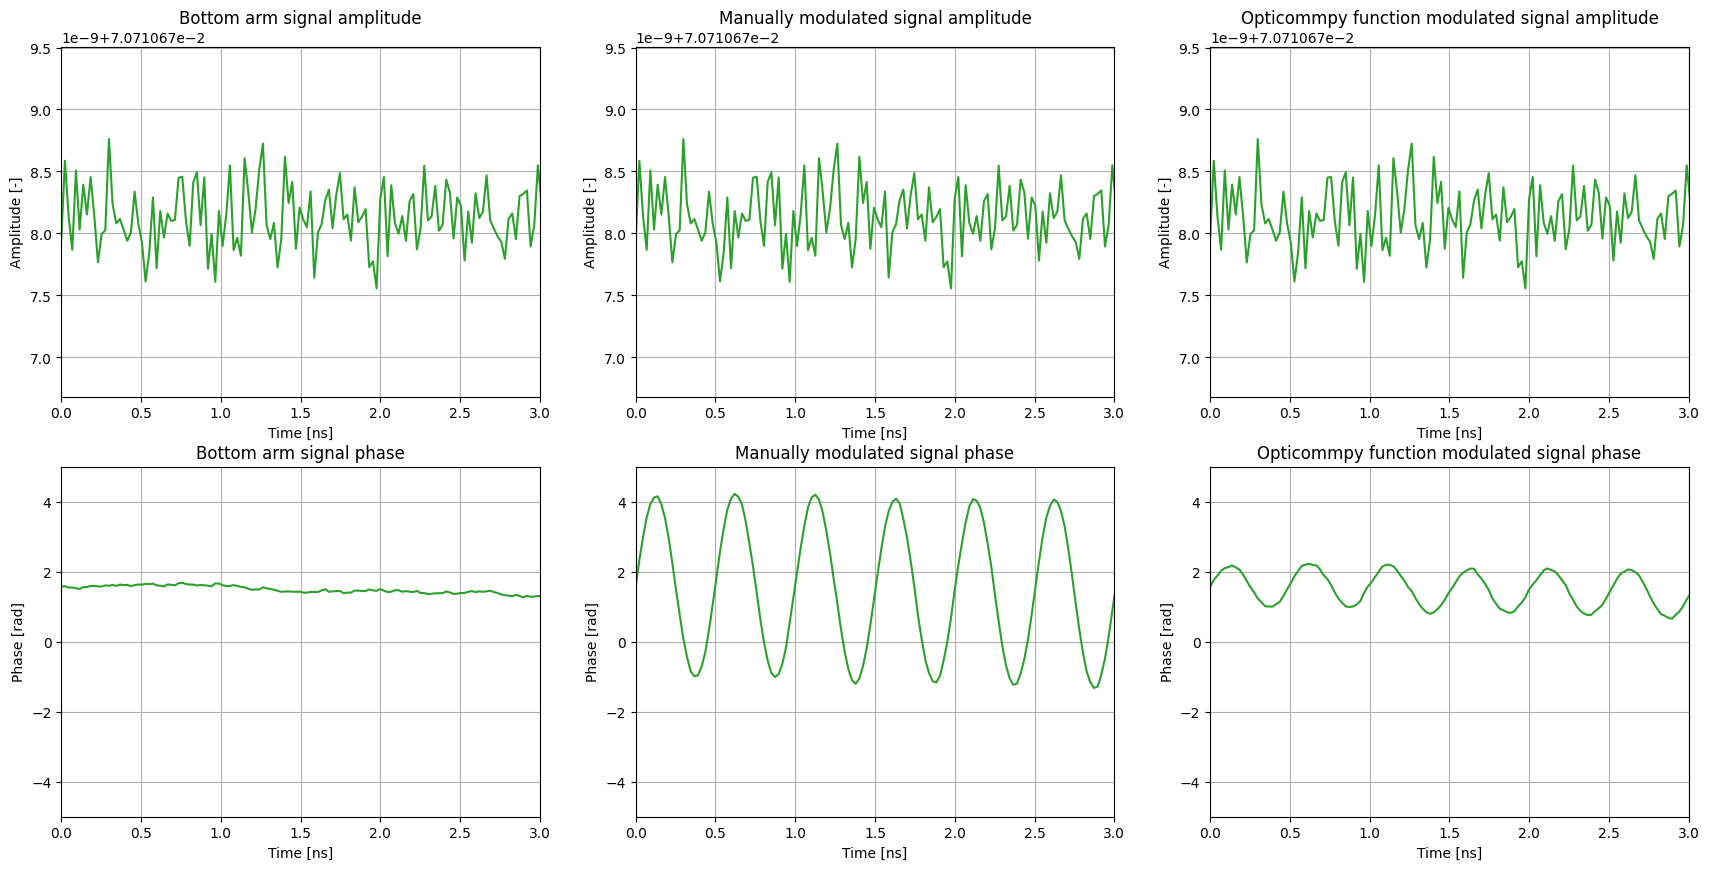

In [4]:
bIdx = 2.63

carrier = OptSig*np.sqrt(1-KConst)*np.exp(KPhase*1j)  # Bottom arm Optical signal
EBottom = carrier*np.exp(1j*bIdx*np.sin(2*np.pi*mFreq*tArray+mPhase)) # Bottom arm Optical signal modulated

elecSig = np.sin(2*np.pi*mFreq*tArray+mPhase)
pmModSignal = pm(carrier,elecSig,5)

fig, ax = plt.subplots(2,3)
fig.set_figheight(10)
fig.set_figwidth(21)

ax[0][0].plot(tArray*1e9,np.abs(carrier),color='C2')
ax[0][0].set_xlim(0,3)
ax[0][0].set_title(f'Bottom arm signal amplitude')
ax[0][0].set_xlabel('Time [ns]')
ax[0][0].set_ylabel('Amplitude [-]')
ax[0][0].grid()

ax[0][1].plot(tArray*1e9,np.abs(EBottom),color='C2')
ax[0][1].set_xlim(0,3)
ax[0][1].set_title(f'Manually modulated signal amplitude')
ax[0][1].set_xlabel('Time [ns]')
ax[0][1].set_ylabel('Amplitude [-]')
ax[0][1].grid()

ax[0][2].plot(tArray*1e9,np.abs(pmModSignal),color='C2')
ax[0][2].set_xlim(0,3)
ax[0][2].set_title(f'Opticommpy function modulated signal amplitude')
ax[0][2].set_xlabel('Time [ns]')
ax[0][2].set_ylabel('Amplitude [-]')
ax[0][2].grid()

ax[1][0].plot(tArray*1e9,np.unwrap(np.angle(carrier)),color='C2')
ax[1][0].set_xlim(0,3)
ax[1][0].set_ylim(-5,5)
ax[1][0].set_title(f'Bottom arm signal phase')
ax[1][0].set_xlabel('Time [ns]')
ax[1][0].set_ylabel('Phase [rad]')
ax[1][0].grid()

ax[1][1].plot(tArray*1e9,np.unwrap(np.angle(EBottom)),color='C2')
ax[1][1].set_xlim(0,3)
ax[1][1].set_ylim(-5,5)
ax[1][1].set_title(f'Manually modulated signal phase')
ax[1][1].set_xlabel('Time [ns]')
ax[1][1].set_ylabel('Phase [rad]')
ax[1][1].grid()

ax[1][2].plot(tArray*1e9,np.unwrap(np.angle(pmModSignal)),color='C2')
ax[1][2].set_xlim(0,3)
ax[1][2].set_ylim(-5,5)
ax[1][2].set_title(f'Opticommpy function modulated signal phase')
ax[1][2].set_xlabel('Time [ns]')
ax[1][2].set_ylabel('Phase [rad]')
ax[1][2].grid()

# Self-Heterodyne Circuit Operations

Delay: 40.02769142377824 us
Attenuation value: 2.64 dB


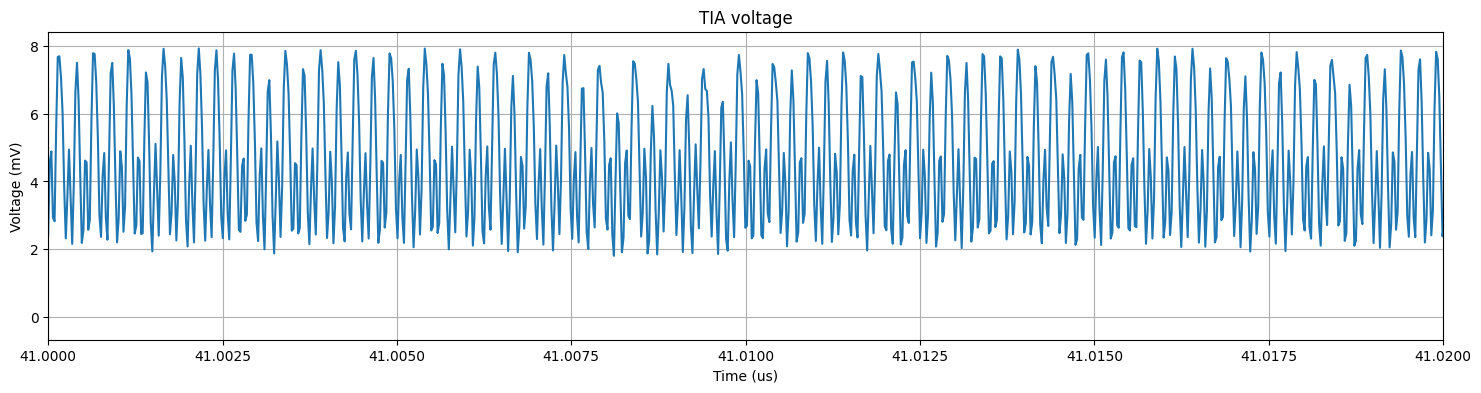

In [5]:
LinearFiber_parameters = parameters()
LinearFiber_parameters.L = SMFLen           # [km] total fiber length
LinearFiber_parameters.alpha = SMFAtt       # [dB/km] fiber attenuation parameter 
LinearFiber_parameters.D = SMFDisp          # [ps/nm/km] chromatic dispersion parameter
LinearFiber_parameters.Fc = c/lmbd  # [Hz] carrier frequency
LinearFiber_parameters.Fs = Fs              # [Hz] sampling frequency 

bIdx = 2          # Modulation index of the electrical modulating signal
vPi = 5               # Modulator vPi [Volts]

TIACutFreq = 11e9  # TIA Filter cuttoff frequency in Hz   
TIAorder = 4  # TIA Filter order      

DemodCutFreq = 0.1e9  # Demodulation Filter cuttoff frequency in Hz     
Demodorder = 4  # Demodulation Filter order

tau = SMFLen/(c*1e-3)    # Fiber Delay
shiftValue = int(len(tArray)*tau/tArray[-1])
print(f'Delay: {tau*1e6} us')
print(f'Attenuation value: {SMFAtt*SMFLen} dB')

EUpper = linearFiberChannel(OptSig*np.sqrt(KConst),LinearFiber_parameters) # Upper arm Optical signal post fiber 
EUpper = shift(EUpper,shiftValue,cval=EUpper[0]) # Applying delay
EUpper = EUpper[shiftValue:]

carrier = OptSig*np.sqrt(1-KConst)*np.exp(KPhase*1j)  # Bottom arm Optical signal
elecSig = vPi*bIdx*np.sin(2*np.pi*mFreq*tArray+mPhase) # Electrical signal for pm modulation
EBottom = pm(carrier,elecSig,vPi)  # PM modulation
EBottom = EBottom[shiftValue:]

timeArray = tArray[shiftValue:]

Epd = KConst*EUpper + (1-KConst)*np.exp(1j*KPhase)*EBottom   # E-Field Incident on Photodiode
Eosa = (1-KConst)*np.exp(1j*KPhase)*EUpper + KConst*EBottom  # E-Field Incident on OSA

IPd = 2*R*np.abs(Epd)**2    # Current Post-Photodiode


# TIA Filter ---------------------------------------------------------

w_norm = TIACutFreq / (Fs/2)
b,a = signal.bessel(N=TIAorder, Wn=w_norm, btype='low', norm='phase')
w, h = signal.freqz(b, a, worN=1024, fs=Fs)
FilteredIPd = signal.lfilter(b, a, IPd)

plt.figure(figsize=(18,4))
plt.plot(timeArray*1e6,FilteredIPd*1e3)
plt.xlim(41,41.02)
plt.xlabel('Time (us)')
plt.ylabel('Voltage (mV)')
plt.title('TIA voltage')
plt.grid()

Q_Sig = FilteredIPd*np.sin(2*np.pi*mFreq*timeArray+mPhase)
I_Sig = -FilteredIPd*np.cos(2*(2*np.pi*mFreq*timeArray+mPhase))

# Demodulation Filtering ----------------------------------------------      

w_norm = DemodCutFreq / (Fs/2)
b,a = signal.bessel(N=Demodorder, Wn=w_norm, btype='low', norm='phase')
w, h = signal.freqz(b, a, worN=1024, fs=Fs)
FilteredQ_Sig = signal.lfilter(b, a, Q_Sig)
FilteredI_Sig = signal.lfilter(b, a, I_Sig)

# fir_coeffs = firwin(
#     numtaps=8000,
#     cutoff=2*DemodCutFreq/Fs,
#     window='hamming',
#     fs=Fs,
#     pass_zero='lowpass'
# )
# w, h = freqz(fir_coeffs, worN=1024, fs=Fs)
# FilteredI_Sig = lfilter(fir_coeffs, 1.0, I_Sig)
# FilteredQ_Sig = lfilter(fir_coeffs, 1.0, Q_Sig)

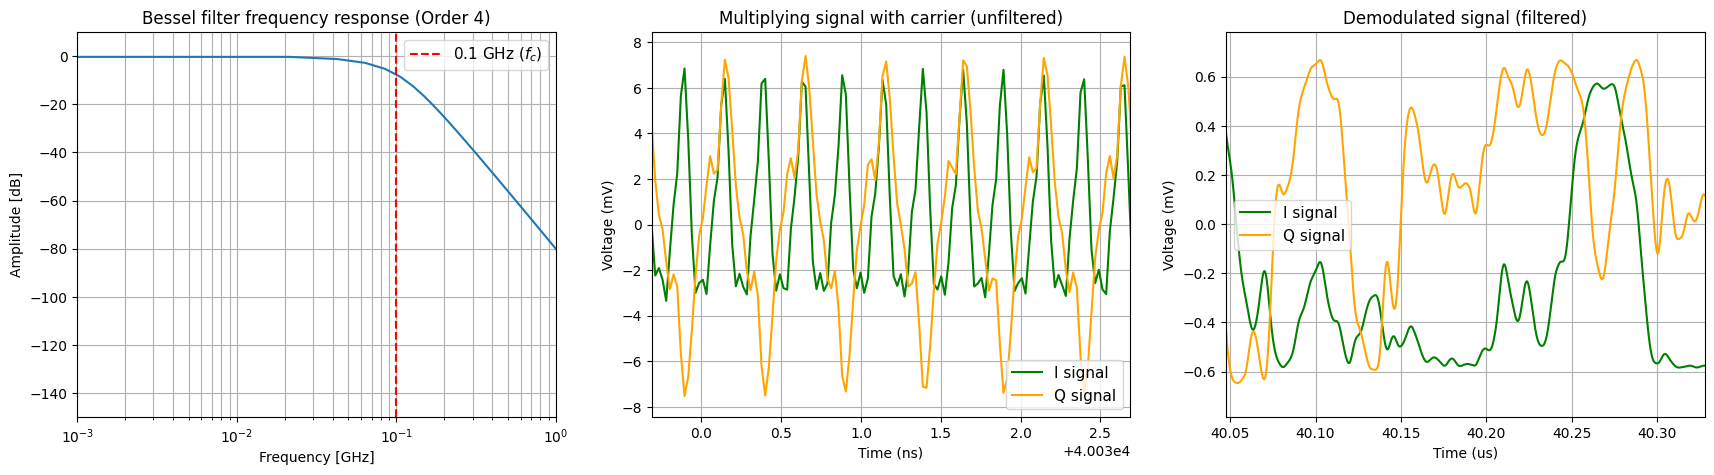

In [6]:
fig, ax = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(21)

StTime = np.min(timeArray*1e9) # Starting time post delay

ax[0].plot(w*1e-9, 20 * np.log10(abs(h)))
ax[0].axvline(DemodCutFreq*1e-9, color='red', linestyle='--', label=f'{DemodCutFreq*1e-9} GHz ($f_c$)')
ax[0].set_xscale('log')
ax[0].set_xlim(0.001,1)
ax[0].set_ylim(-150,10)
ax[0].set_title(f'Bessel filter frequency response (Order {Demodorder})')
ax[0].set_xlabel('Frequency [GHz]')
ax[0].set_ylabel('Amplitude [dB]')
ax[0].margins(0, 0.1)
ax[0].grid(which='both', axis='both')
ax[0].legend(fontsize=11)

ax[1].plot(timeArray*1e9,I_Sig*1e3, label='I signal', color='green')
ax[1].plot(timeArray*1e9,Q_Sig*1e3, label='Q signal', color='orange')
ax[1].set_xlim(StTime+2,StTime+5)
ax[1].set_xlabel('Time (ns)')
ax[1].set_ylabel('Voltage (mV)')
ax[1].set_title('Multiplying signal with carrier (unfiltered)')
ax[1].grid()
ax[1].legend(fontsize=11)

ax[2].plot(timeArray*1e6,FilteredI_Sig*1e3, label='I signal', color='green')
ax[2].plot(timeArray*1e6,FilteredQ_Sig*1e3, label='Q signal', color='orange')
ax[2].set_xlim(StTime*1e-3+0.02,StTime*1e-3+0.3)
ax[2].set_xlabel('Time (us)')
ax[2].set_ylabel('Voltage (mV)')
ax[2].set_title('Demodulated signal (filtered)')
ax[2].grid()
ax[2].legend(fontsize=11)

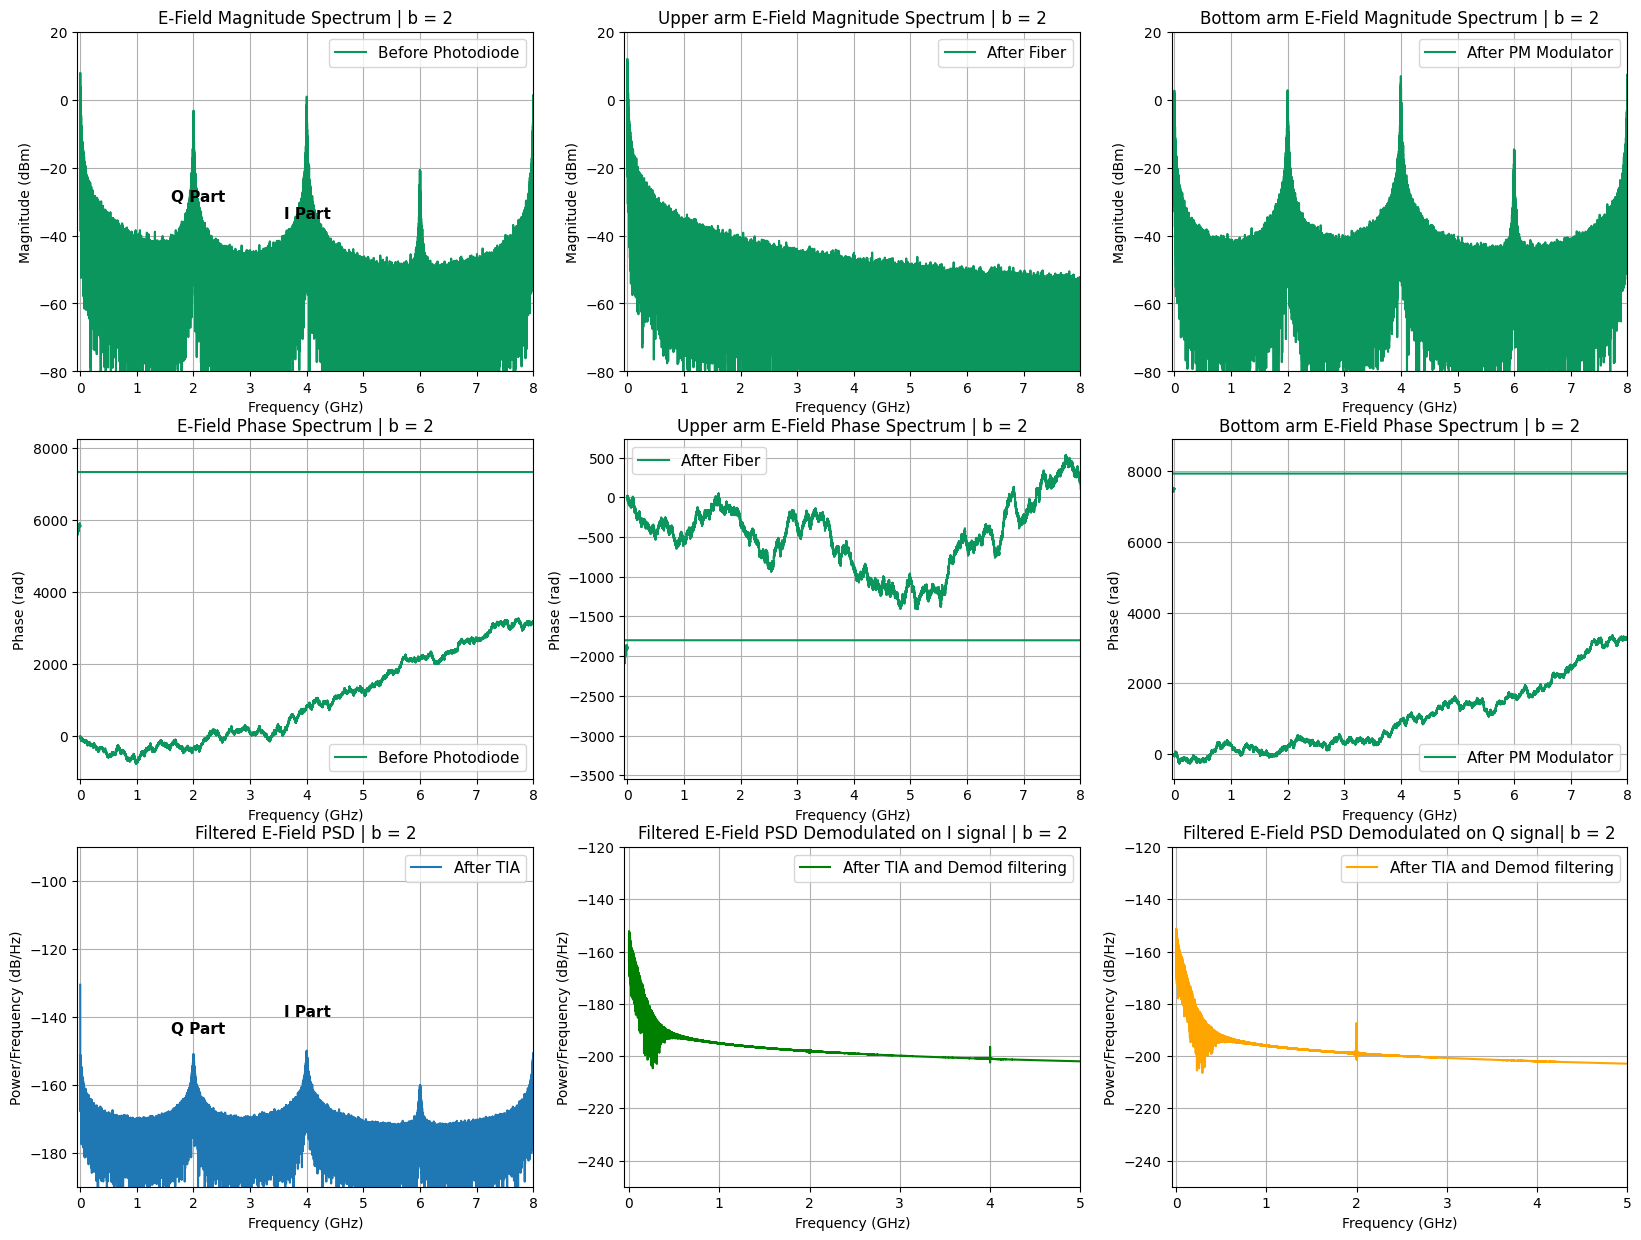

In [8]:
fig, ax = plt.subplots(3,3)
fig.set_figheight(15)
fig.set_figwidth(20)

StTime = np.min(timeArray*1e12) # Starting time post delay

spectrum, freq = mlab.magnitude_spectrum(Epd, Fs=Fs, window=mlab.window_none,sides='onesided')
ax[0][0].plot(freq*1e-9,20*np.log10(spectrum*1e3), label='Before Photodiode', color='#0b965e')
# ax[0][0].magnitude_spectrum(Epd, Fs=Fs, color='C1', window=mlab.window_none)
ax[0][0].text(1.6,-30,'Q Part',fontweight='bold',fontsize=11)
ax[0][0].text(3.6,-35,'I Part',fontweight='bold',fontsize=11)
ax[0][0].set_xlabel('Frequency (GHz)')
ax[0][0].set_ylabel('Magnitude (dBm)')
ax[0][0].set_xlim(-0.05,8)
ax[0][0].set_ylim(-80,20)
ax[0][0].set_title(f'E-Field Magnitude Spectrum | b = {bIdx}')
ax[0][0].grid()
ax[0][0].legend(fontsize=11)

spectrum, freq = mlab.magnitude_spectrum(EUpper, Fs=Fs, window=mlab.window_none,sides='onesided')
ax[0][1].plot(freq*1e-9,20*np.log10(spectrum*1e3), label='After Fiber', color='#0b965e')
ax[0][1].set_xlabel('Frequency (GHz)')
ax[0][1].set_ylabel('Magnitude (dBm)')
ax[0][1].set_xlim(-0.05,8)
ax[0][1].set_ylim(-80,20)
ax[0][1].set_title(f'Upper arm E-Field Magnitude Spectrum | b = {bIdx}')
ax[0][1].grid()
ax[0][1].legend(fontsize=11)

spectrum, freq = mlab.magnitude_spectrum(EBottom, Fs=Fs, window=mlab.window_none,sides='onesided')
ax[0][2].plot(freq*1e-9,20*np.log10(spectrum*1e3), label='After PM Modulator', color='#0b965e')
ax[0][2].set_xlabel('Frequency (GHz)')
ax[0][2].set_ylabel('Magnitude (dBm)')
ax[0][2].set_xlim(-0.05,8)
ax[0][2].set_ylim(-80,20)
ax[0][2].set_title(f'Bottom arm E-Field Magnitude Spectrum | b = {bIdx}')
ax[0][2].grid()
ax[0][2].legend(fontsize=11)

freq = np.fft.fftfreq(len(Epd), d=1/Fs)
spectrumAngle = np.angle(np.fft.fft(Epd)/len(Epd))
ax[1][0].plot(freq*1e-9,np.unwrap(spectrumAngle), label='Before Photodiode', color='#0b965e')
ax[1][0].set_xlabel('Frequency (GHz)')
ax[1][0].set_ylabel('Phase (rad)')
ax[1][0].set_xlim(-0.05,8)
# ax[1][0].set_ylim(-800,800)
ax[1][0].set_title(f'E-Field Phase Spectrum | b = {bIdx}')
ax[1][0].grid()
ax[1][0].legend(fontsize=11)

freq = np.fft.fftfreq(len(EUpper), d=1/Fs)
spectrumAngle = np.angle(np.fft.fft(EUpper)/len(EUpper))
ax[1][1].plot(freq*1e-9,np.unwrap(spectrumAngle), label='After Fiber', color='#0b965e')
ax[1][1].set_xlabel('Frequency (GHz)')
ax[1][1].set_ylabel('Phase (rad)')
ax[1][1].set_xlim(-0.05,8)
# ax[1][1].set_ylim(-500,1000)
ax[1][1].set_title(f'Upper arm E-Field Phase Spectrum | b = {bIdx}')
ax[1][1].grid()
ax[1][1].legend(fontsize=11)

freq = np.fft.fftfreq(len(EBottom), d=1/Fs)
spectrumAngle = np.angle(np.fft.fft(EBottom)/len(EBottom))
ax[1][2].plot(freq*1e-9,np.unwrap(spectrumAngle), label='After PM Modulator', color='#0b965e')
ax[1][2].set_xlabel('Frequency (GHz)')
ax[1][2].set_ylabel('Phase (rad)')
ax[1][2].set_xlim(-0.05,8)
# ax[1][2].set_ylim(-800,200)
ax[1][2].set_title(f'Bottom arm E-Field Phase Spectrum | b = {bIdx}')
ax[1][2].grid()
ax[1][2].legend(fontsize=11)

# AFTER PHOTODIODE ---------------------------------------------------------------------

spectrum, freq = mlab.magnitude_spectrum(FilteredIPd, Fs=Fs, window=mlab.window_none,sides='onesided')
spectrum = spectrum/Fs
ax[2][0].plot(freq*1e-9,10*np.log10(spectrum), label='After TIA')
ax[2][0].text(1.6,-145,'Q Part',fontweight='bold',fontsize=11)
ax[2][0].text(3.6,-140,'I Part',fontweight='bold',fontsize=11)
ax[2][0].set_xlabel('Frequency (GHz)')
ax[2][0].set_ylabel('Power/Frequency (dB/Hz)')
ax[2][0].set_xlim(-0.05,8)
ax[2][0].set_ylim(-190,-90)
ax[2][0].set_title(f'Filtered E-Field PSD | b = {bIdx}')
ax[2][0].grid()
ax[2][0].legend(fontsize=11)

spectrum, freq = mlab.magnitude_spectrum(FilteredI_Sig, Fs=Fs, window=mlab.window_none,sides='onesided')
spectrum = spectrum/Fs
ax[2][1].plot(freq*1e-9,10*np.log10(spectrum), label='After TIA and Demod filtering', color='green')
ax[2][1].set_xlabel('Frequency (GHz)')
ax[2][1].set_ylabel('Power/Frequency (dB/Hz)')
ax[2][1].set_xlim(-0.05,5)
ax[2][1].set_ylim(-250,-120)
ax[2][1].set_title(f'Filtered E-Field PSD Demodulated on I signal | b = {bIdx}')
ax[2][1].grid()
ax[2][1].legend(fontsize=11)

spectrum, freq = mlab.magnitude_spectrum(FilteredQ_Sig, Fs=Fs, window=mlab.window_none,sides='onesided')
spectrum = spectrum/Fs
ax[2][2].plot(freq*1e-9, 10*np.log10(spectrum), label='After TIA and Demod filtering', color='orange')
ax[2][2].set_xlabel('Frequency (GHz)')
ax[2][2].set_ylabel('Power/Frequency (dB/Hz)')
ax[2][2].set_xlim(-0.05,5)
ax[2][2].set_ylim(-250,-120)
ax[2][2].set_title(f'Filtered E-Field PSD Demodulated on Q signal| b = {bIdx}')
ax[2][2].grid()
ax[2][2].legend(fontsize=11)

# Phase-Noise Characterization

## E-Field PSD

BestleftMark: 1994.1467872727874 MHz
BestleftMark: 1995.4957501320434 MHz
BestleftMark: 1996.8117663722737 MHz
BestleftMark: 1998.0743879267332 MHz
BestleftMark: 1998.4844730613913 MHz
BestleftMark: 1999.725033462721 MHz
BestrightMark: 2000.2205220194157 MHz


<IPython.core.display.Math object>

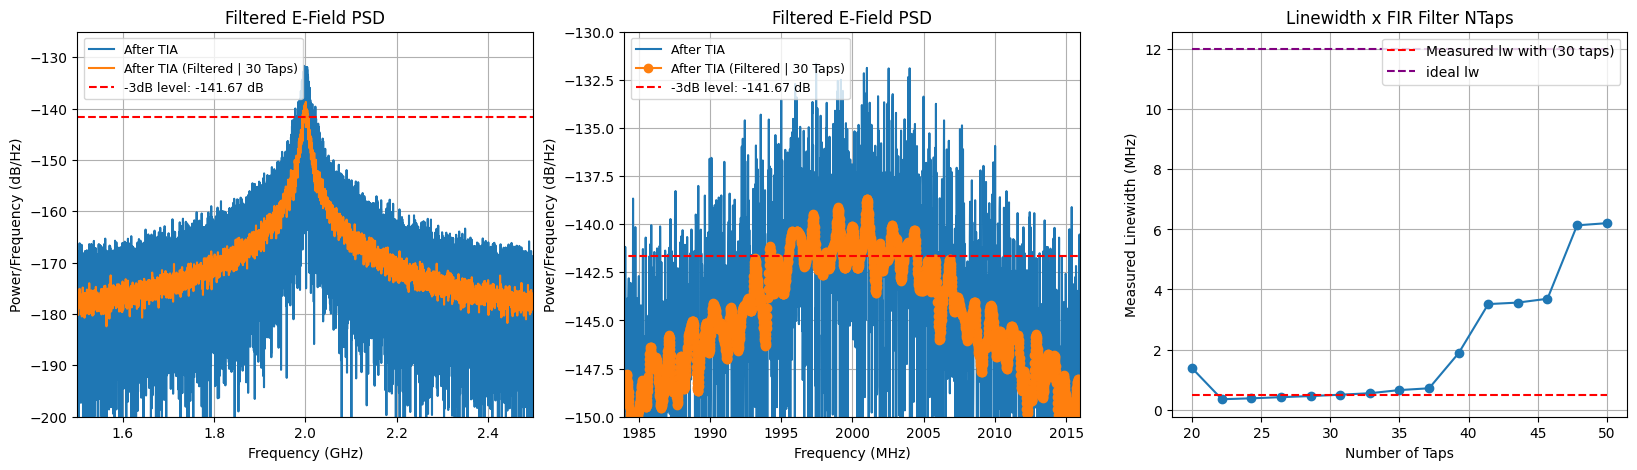

In [9]:
fig, ax = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(20)

tapsArray = np.linspace(20,50,15)
lwArray = np.zeros(len(tapsArray))

centerFreq = 2e9
cutLims = [1.45e9,2.55e9]
# spectrum, freq = mlab.magnitude_spectrum(FilteredIPd, Fs=Fs, window=mlab.window_none,sides='onesided')
# spectrum = spectrum*np.conj(spectrum)
freq = np.fft.fftfreq(len(FilteredIPd), d=1/Fs)
freq = freq[:int(len(freq)/2)]
spectrum = np.abs(np.fft.fft(FilteredIPd))**2/(len(FilteredIPd)*Fs)
spectrum = spectrum[:int(len(spectrum)/2)]

initFreq = int(cutLims[0]/freq[-1]*len(freq))
endFreq = int(cutLims[1]/freq[-1]*len(freq))

freq = freq[initFreq:endFreq]
spectrum =  10*np.log10(spectrum[initFreq:endFreq])

# Filter spectrum
Ntaps = 30
b = signal.firwin(numtaps = Ntaps, cutoff = 1e-5, window='hamming')
FilteredSpec = firFilter(b, spectrum)[Ntaps:-Ntaps]  

ax[0].plot(freq*1e-9,spectrum, label='After TIA')
ax[0].plot(freq[Ntaps:-Ntaps]*1e-9,FilteredSpec, label=f'After TIA (Filtered | {Ntaps} Taps)')
ax[0].hlines(np.max(FilteredSpec)-3,xmin=cutLims[0]*1e-9, xmax=cutLims[1]*1e-9, color='red', linestyle='--', label=f'-3dB level: {np.round(np.max(FilteredSpec)-3,2)} dB')
ax[0].set_xlabel('Frequency (GHz)')
ax[0].set_ylabel('Power/Frequency (dB/Hz)')
ax[0].set_xlim(1.5,2.5)
ax[0].set_ylim(-200,-125)
ax[0].set_title(f'Filtered E-Field PSD')
ax[0].grid()
ax[0].legend(fontsize=9)

ax[1].plot(freq*1e-6,spectrum, label='After TIA')
ax[1].plot(freq[Ntaps:-Ntaps]*1e-6,FilteredSpec,'-o', label=f'After TIA (Filtered | {Ntaps} Taps)')
ax[1].hlines(np.max(FilteredSpec)-3,xmin=cutLims[0]*1e-6, xmax=cutLims[1]*1e-6, color='red', linestyle='--', label=f'-3dB level: {np.round(np.max(FilteredSpec)-3,2)} dB')
ax[1].set_xlabel('Frequency (MHz)')
ax[1].set_ylabel('Power/Frequency (dB/Hz)')
ax[1].set_xlim(2000 - 16 , 2000 + 16)
ax[1].set_ylim(-150,-130)
ax[1].set_title(f'Filtered E-Field PSD')
ax[1].grid()
ax[1].legend(fontsize=9)

BestrightMark = 0
BestleftMark = 0

freqCutted = freq[Ntaps:-Ntaps]

for i in range(len(FilteredSpec)-1):
    if FilteredSpec[i+1] >= np.max(FilteredSpec)-3 and FilteredSpec[i] < np.max(FilteredSpec)-3:
        # print(f'leftMark between {np.round(freqCutted[i]*1e-6,2)} and {np.round(freqCutted[i+1]*1e-6,2)} MHz')
        leftMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freqCutted[i+1]-freqCutted[i]) + freqCutted[i]
        if (np.abs(leftMark-centerFreq) < np.abs(BestleftMark-centerFreq) and leftMark < centerFreq):
            BestleftMark = leftMark
            print(f'BestleftMark: {BestleftMark*1e-6} MHz')
    elif FilteredSpec[i+1] < np.max(FilteredSpec)-3 and FilteredSpec[i] >= np.max(FilteredSpec)-3:
        # print(f'rightMark between {np.round(freqCutted[i]*1e-6,2)} and {np.round(freqCutted[i+1]*1e-6,2)} MHz')
        rightMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freqCutted[i+1]-freqCutted[i]) + freqCutted[i]
        if (np.abs(rightMark-centerFreq) < np.abs(BestrightMark-centerFreq) and rightMark > centerFreq):
            BestrightMark = rightMark
            print(f'BestrightMark: {BestrightMark*1e-6} MHz')

delF = BestrightMark*1e-6-BestleftMark*1e-6
display(Math('Measured~Linewidth = %5.6f~MHz~~~|~~~DFB~Linewidth = %5.6f~MHz' %(delF, delF/2 )))

for j in range(len(tapsArray)):
    NtapsIt = int(np.floor(tapsArray[j]))
    b = signal.firwin(numtaps = NtapsIt, cutoff = 1e-5, window='hamming')
    FilteredSpec = firFilter(b, spectrum)[NtapsIt:-NtapsIt]  

    BestrightMark = 0
    BestleftMark = 0

    for i in range(len(FilteredSpec)-1):
        if FilteredSpec[i+1] >= np.max(FilteredSpec)-3 and FilteredSpec[i] < np.max(FilteredSpec)-3:
            leftMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freqCutted[i+1]-freqCutted[i]) + freqCutted[i]
            if (np.abs(leftMark-centerFreq) < np.abs(BestleftMark-centerFreq) and leftMark < centerFreq):
                BestleftMark = leftMark
        elif FilteredSpec[i+1] < np.max(FilteredSpec)-3 and FilteredSpec[i] >= np.max(FilteredSpec)-3:
            rightMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freqCutted[i+1]-freqCutted[i]) + freqCutted[i]
            if (np.abs(rightMark-centerFreq) < np.abs(BestrightMark-centerFreq) and rightMark > centerFreq):
                BestrightMark = rightMark
    
    lwArray[j] = BestrightMark*1e-6-BestleftMark*1e-6

ax[2].plot(tapsArray,lwArray,'-o')
ax[2].set_xlabel('Number of Taps')
ax[2].set_ylabel('Measured Linewidth (MHz)')
ax[2].set_title(f'Linewidth x FIR Filter NTaps')
ax[2].hlines(delF,xmin=tapsArray[0], xmax=tapsArray[-1], color='red', linestyle='--', label=f'Measured lw with ({Ntaps} taps)')
ax[2].hlines(laser_parameters.lw*2e-6,xmin=tapsArray[0], xmax=tapsArray[-1], color='purple', linestyle='--', label=f'ideal lw')
ax[2].grid()
ax[2].legend(fontsize=10)

## Frequency Modulation Noise Spectrum

Fs = 43.52 GSamples/s
[0.00000000e+00 1.79664030e+04 3.59328060e+04 ... 2.17599371e+10
 2.17599551e+10 2.17599731e+10]


C:\Users\Caio\AppData\Local\Temp\ipykernel_19384\1914440037.py:60: RuntimeWarning: invalid value encountered in divide
  convertedSpectrum = spectrumDPhase*freqDPhase**2/(4*np.sin(np.pi*freqDPhase*Ts)**2)


<IPython.core.display.Math object>

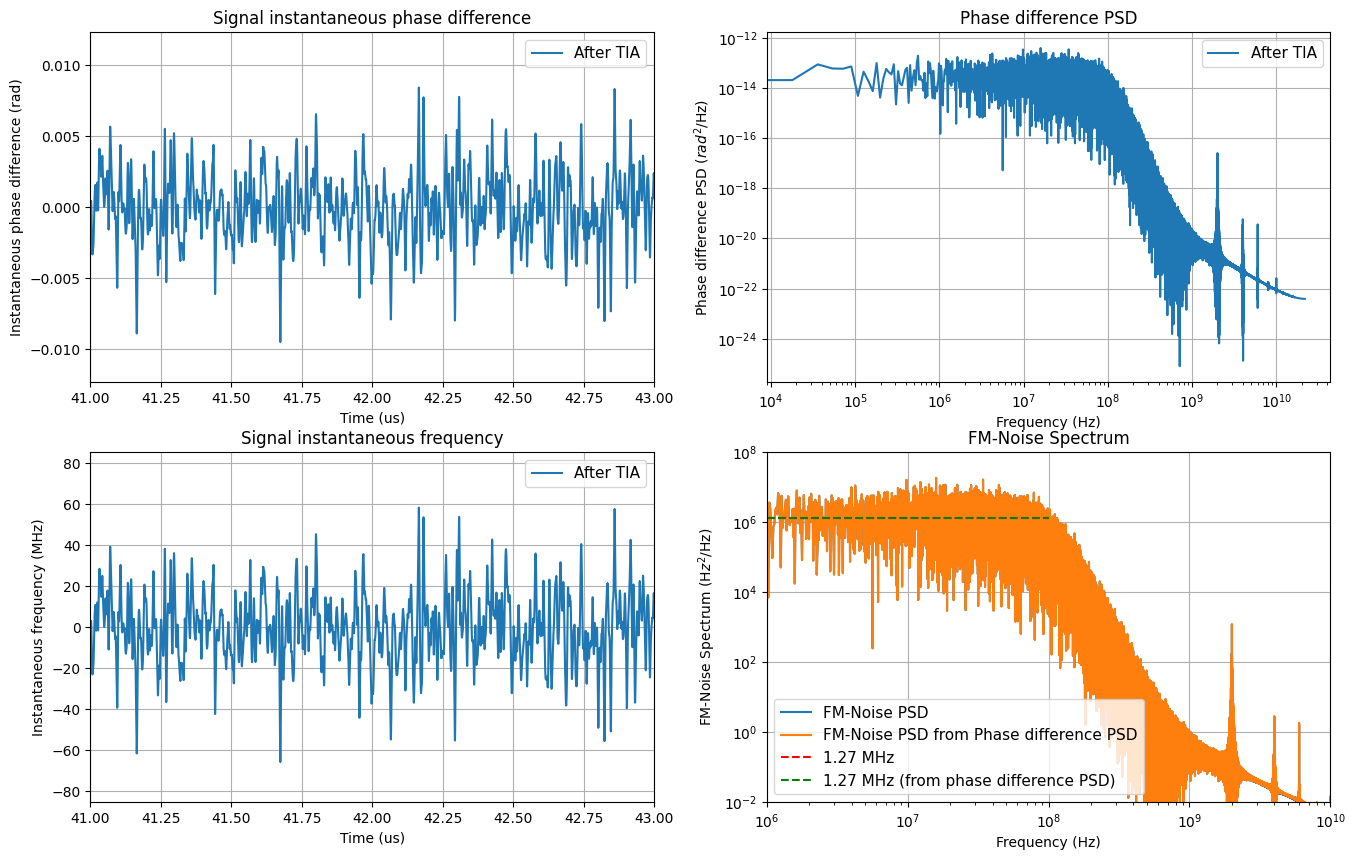

In [10]:
CplxSig = FilteredI_Sig + 1j*FilteredQ_Sig
# CplxSig = I_Sig + 1j*Q_Sig
instPhaseDiff = np.unwrap(np.angle(CplxSig)) - shift(np.unwrap(np.angle(CplxSig)),1,cval=0)     # Instantaneous phase difference
instFreq = instPhaseDiff / (2*np.pi*Ts)                                                         # Instantaneous frequency

print(f'Fs = {(1/Ts)*1e-9} GSamples/s')

fig, ax = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(16)

StTime = np.min(timeArray*1e6) # Starting time post delay

instPhaseDiff = instPhaseDiff[10000:-20000]
# spectrumDPhase, freqDPhase = mlab.magnitude_spectrum(instPhaseDiff, Fs=Fs, window=mlab.window_none,sides='onesided')
# spectrumDPhase = spectrumDPhase*np.conj(spectrumDPhase)
freqDPhase = np.fft.fftfreq(len(instPhaseDiff), d=1/Fs)
freqDPhase = freqDPhase[:int(len(freqDPhase)/2)]
spectrumDPhase = np.abs(np.fft.fft(instPhaseDiff))**2/(len(instPhaseDiff)*Fs)
spectrumDPhase = spectrumDPhase[:int(len(spectrumDPhase)/2)]

ax[0][0].plot(timeArray[10000:-20000]*1e6,instPhaseDiff, label='After TIA')
ax[0][0].set_xlabel('Time (us)')
ax[0][0].set_ylabel('Instantaneous phase difference (rad)')
ax[0][0].set_title(f'Signal instantaneous phase difference')
ax[0][0].set_xlim(41 , 43)
ax[0][0].grid()
ax[0][0].legend(fontsize=11)

ax[0][1].plot(freqDPhase,spectrumDPhase, label='After TIA')
ax[0][1].set_xscale('log')
ax[0][1].set_yscale('log')
ax[0][1].set_xlabel('Frequency (Hz)')
ax[0][1].set_ylabel('Phase difference PSD ($rad^2$/Hz)')
# ax[0][1].set_xlim(1e6 , 1e10)
# ax[0][1].set_ylim(1e1 , 1e13)
ax[0][1].set_title(f'Phase difference PSD')
ax[0][1].grid()
ax[0][1].legend(fontsize=11)

instFreq = instFreq[10000:-20000]
instFreq = instFreq-np.mean(instFreq)
# spectrum, freq = mlab.magnitude_spectrum(instFreq, Fs=Fs, window=mlab.window_none,sides='onesided')
# spectrum = spectrum*np.conj(spectrum)
freq = np.fft.fftfreq(len(instFreq), d=1/Fs)
freq = freq[:int(len(freq)/2)]
spectrum = np.abs(np.fft.fft(instFreq))**2/(len(instFreq)*Fs)
spectrum = spectrum[:int(len(spectrum)/2)]

ax[1][0].plot(timeArray[10000:-20000]*1e6,instFreq*1e-6, label='After TIA')
ax[1][0].set_xlabel('Time (us)')
ax[1][0].set_xlim(41 , 43)
# ax[0].set_xlim(StTime+0.1,StTime+0.3)
# ax[0].set_ylim(-100,100)
ax[1][0].set_ylabel('Instantaneous frequency (MHz)')
ax[1][0].set_title(f'Signal instantaneous frequency')
ax[1][0].grid()
ax[1][0].legend(fontsize=11)

convertedSpectrum = spectrumDPhase*freqDPhase**2/(4*np.sin(np.pi*freqDPhase*Ts)**2)

cutLims = [1e6,1e8]
initFreq = int(cutLims[0]/freq[-1]*len(freq))
endFreq = int(cutLims[1]/freq[-1]*len(freq))
Measurefreq = freq[initFreq:endFreq]
Measurespectrum = spectrum[initFreq:endFreq]
print(freq)

initFreqDP = int(cutLims[0]/freqDPhase[-1]*len(freqDPhase))
endFreqDP = int(cutLims[1]/freqDPhase[-1]*len(freqDPhase))
MeasurefreqDP = freqDPhase[initFreqDP:endFreqDP]
MeasurespectrumDP = convertedSpectrum[initFreqDP:endFreqDP]

display(Math('Measured~Linewidth = %5.6f~MHz~~~|~~~DFB~Linewidth = %5.6f~MHz' %(np.pi*np.round(np.mean(Measurespectrum))*1e-6, np.pi*np.round(np.mean(Measurespectrum))*1e-6/2)))

ax[1][1].plot(freq,spectrum, label='FM-Noise PSD')
ax[1][1].plot(freqDPhase,convertedSpectrum, label='FM-Noise PSD from Phase difference PSD')
ax[1][1].hlines(np.mean(Measurespectrum),xmin=cutLims[0], xmax=cutLims[1], color='red', linestyle='--', label=f'{np.round(np.mean(Measurespectrum)*1e-6,2)} MHz')
ax[1][1].hlines(np.mean(MeasurespectrumDP),xmin=cutLims[0], xmax=cutLims[1], color='green', linestyle='--', label=f'{np.round(np.mean(MeasurespectrumDP)*1e-6,2)} MHz (from phase difference PSD)')
ax[1][1].set_xscale('log')
ax[1][1].set_yscale('log')
ax[1][1].set_xlabel('Frequency (Hz)')
ax[1][1].set_ylabel('FM-Noise Spectrum (H$z^2$/Hz)')
ax[1][1].set_xlim(1e6 , 1e10)
ax[1][1].set_ylim(1e-2 , 1e8)
ax[1][1].set_title(f'FM-Noise Spectrum')
ax[1][1].grid()
ax[1][1].legend(fontsize=11)

## Phase-Error Variance

<IPython.core.display.Math object>

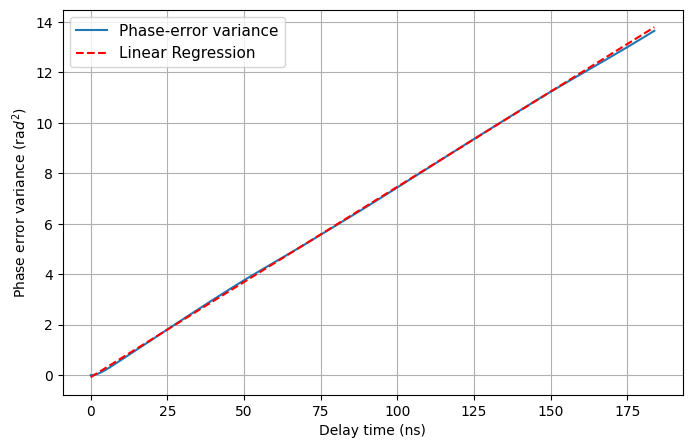

In [11]:
ShiftArray = np.linspace(0,8000,1200)

CplxSig = FilteredI_Sig + 1j*FilteredQ_Sig
varianceArray = np.zeros(len(ShiftArray))

for i in range(len(ShiftArray)):
    phaseDiff = np.unwrap(np.angle(CplxSig)) - shift(np.unwrap(np.angle(CplxSig)),ShiftArray[i],cval=0)  # Instantaneous frequency
    varianceArray[i] = np.mean(phaseDiff[200+int(ShiftArray[i]):]**2)

polyArray = np.polyfit(ShiftArray[:1000]*Ts,varianceArray[:1000],1)

plt.figure(figsize=(8,5))
plt.plot(ShiftArray*Ts*1e9,varianceArray,label='Phase-error variance')
plt.plot(ShiftArray*Ts*1e9,polyArray[0]*ShiftArray*Ts+polyArray[1],'--',color='red',label='Linear Regression')
plt.ylabel('Phase error variance (ra$d^2$)')
plt.xlabel('Delay time (ns)')
plt.grid()
plt.legend(fontsize=11)

display(Math('Measured~Linewidth = %5.6f~MHz~~~|~~~DFB~Linewidth = %5.6f~MHz' %(polyArray[0]*1e-6/(2*np.pi) , (polyArray[0]*1e-6/(2*np.pi))/2 )))

According to the reference *Characterization of Semiconductor-Laser Phase Noise with Digital Coherent Receivers* by Kazuro KIKUCHI, getting the 3-db bandwidth $\delta f$, the other methods can be calculated:
$$\text{FM noise white spectral density: }  \delta f / \pi$$
$$\text{Phase error variance: }  \sigma(\tau)^2 = 2 \pi \delta f \tau$$

In [52]:
display(Math('FM~noise~white~spectral~density = %5.6f ~MHz~(DFB)~~~|~~~ Phase~error~variance~slope = %5.6f~(DFB)' %(delF/(2*np.pi),2*np.pi*delF/2)))

<IPython.core.display.Math object>